In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from scipy import interpolate
from scipy import integrate
from scipy.optimize import fsolve
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import healpy as hp

import os
from os import listdir
from os.path import isfile, join

from multiprocessing import Pool
import time
from numba import njit

import sys
from tqdm import tqdm

In [6]:
href=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoflag = FlatLambdaCDM(H0=href, Om0=Om0GLOB)
@njit
def E_z(z, H0, Om):
    return np.sqrt(Om*(1+z)**3+(1-Om))

def r_z(z, H0, Om):
    c = clight
    integrand = lambda x : 1/E_z(x, H0, Om)
    integral, error = integrate.quad(integrand, 0, z)
    return integral*c/H0

def Dl_z(z, H0, Om):
    return r_z(z, H0, Om)*(1+z)
@njit
def phi2RA(phi):
    ret=np.rad2deg(phi)
    return ret
@njit
def theta2DEC(theta):
    ret=np.rad2deg(0.5*np.pi-theta)
    return ret
@njit
def RA2phi(RA):
    ret=np.deg2rad(RA)
    return ret
@njit
def DEC2theta(DEC):
    ret=0.5 * np.pi - np.deg2rad(DEC)
    return ret

In [3]:
#Catalogue path
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
#all_event=os.listdir()
#print(all_event)
save_cat_path='/home/rciancarella/DarkSirensStat/MyDSStat/'

# Loading The Flagship 

In [4]:
flag = pd.read_csv('GLADE_flagship.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
flag.columns=colnames

In [10]:
z_flag_min=flag['z'].min()
z_flag_max=flag['z'].max()
Nobj=flag.shape[0]
dl_flag_min=flag['dl'].min()
dl_flag_max=flag['dl'].max()
RA_flag_min=flag['right_ascension_degrees'].min()
RA_flag_max=flag['right_ascension_degrees'].max()
DEC_flag_min=flag['declination_degrees'].min()
DEC_flag_max=flag['declination_degrees'].max()
phi_flag_min=RA2phi(RA_flag_min)
phi_flag_max=RA2phi(RA_flag_max)
theta_flag_min=DEC2theta(DEC_flag_max)
theta_flag_max=DEC2theta(DEC_flag_min)
print('MotherCat Info:')
print('ref Cosmology={}'.format(cosmoflag))
print('Num of objects={}'.format(Nobj))
print('phi min={}, phi max={}, theta min={}, theta max={}'.format(phi_flag_min,phi_flag_max,theta_flag_min,theta_flag_max))
print('z min={},z max={}'.format(z_flag_min,z_flag_max))
print('dl min={}, dl max={}'.format(dl_flag_min, dl_flag_max))

MotherCat Info:
ref Cosmology=FlatLambdaCDM(H0=67.0 km / (Mpc s), Om0=0.319, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)
Num of objects=14047533
phi min=2.719426608367094e-07, phi max=1.5707961936368422, theta min=0.0002976082518162393, theta max=1.5707962750520588
z min=0.7887375950813293,z max=2.01294469833374
dl min=5103.691763013905, dl max=16104.59835705387


In [11]:
delta_phi=phi_flag_max-phi_flag_min
theta_part=np.cos(theta_flag_min)-np.cos(theta_flag_max)
integrand=lambda x:clight*(cosmoflag.comoving_distance(x).value)**2/(cosmoflag.H(x).value)
z_part=integrate.quad(integrand,z_flag_min,z_flag_max)[0]

Volume=delta_phi*theta_part*z_part#integrand
print('Cat Volume {} Gpc^3'.format(Volume/1000**3))
Density=Nobj/Volume
print('Cat Density {} #/Mpc^3'.format(Density))

Cat Volume 67.79817302600848 Gpc^3
Cat Density 0.00020719633543238896 #/Mpc^3


# Evaluating N(z)
chiedere se conviene usare direttamente la flag o la N(z) che mi aveva dato Melita

Text(0, 0.5, '$N(z)$')

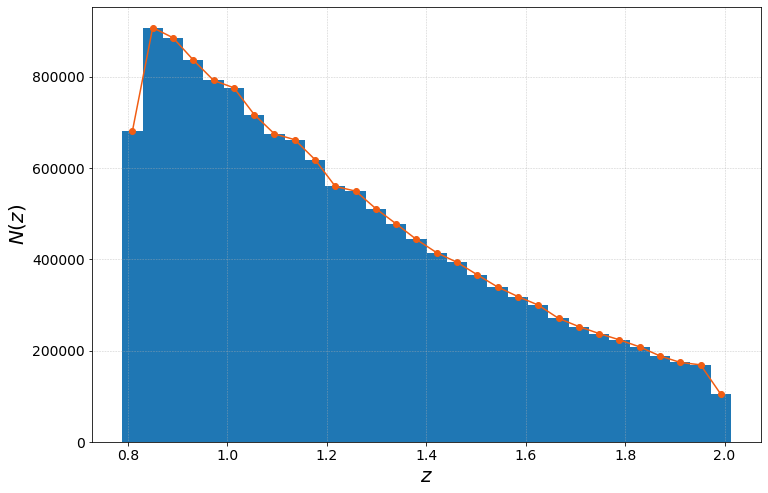

In [34]:
z_flag=np.asarray(flag['z'])
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
(n, bins, patches)=ax.hist(z_flag,bins=nbins,range=(z_flag_min,z_flag_max))
half_step=(bins[1]-bins[0])/2
mybins=bins[:-1]+half_step
myN=interpolate.interp1d(mybins,n,kind='cubic',fill_value='extrapolate')
ax.scatter(mybins,n,color=colors[3])
ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

# Make the True Universe
First we need to generate an uniform catalogue in comoving volume. This imply a cosmology. We need a fixed and constant comoving density. The number of object in the most pupulated bin of the data must be the same as the uniform cat

In [47]:
nmax=n.max()
idx=np.where(n==nmax)[0]
zbin_min=bins[idx]
z_bin_max=bins[idx+1]
integrand=lambda x:clight*(cosmoflag.comoving_distance(x).value)**2/(cosmoflag.H(x).value)
z_part=integrate.quad(integrand,zbin_min,z_bin_max)[0]
bin_vol=theta_part*delta_phi*z_part
unif_density=nmax/bin_vol
uniform_numb=int(unif_density*Volume)+1
#-----------------------------------------------------------------------------
dcom_min=cosmoflag.comoving_distance(z_flag_min).value
dcom_max=cosmoflag.comoving_distance(z_flag_max).value
dl_min=cosmoflag.luminosity_distance(z_flag_min).value
dl_max=cosmoflag.luminosity_distance(z_flag_max).value
#-----------------------------------------------------------------------------
print('Catalogue:\nz_min={}, z_max={},\nphi_min={}, phi_max={}, theta_min={}, theta_max={}'
      .format(z_flag_min,z_flag_max,phi_flag_min,phi_flag_max,theta_flag_min,theta_flag_max))


Catalogue:
z_min=0.7887375950813293, z_max=2.01294469833374,
phi_min=2.719426608367094e-07, phi_max=1.5707961936368422, theta_min=0.0002976082518162393, theta_max=1.5707962750520588


In [56]:
cat_name='Uniform_from_flag_big.txt'


#------------------points generator------------------
u = np.random.uniform(0,1,size=uniform_numb) # uniform random vector of size nsamp
dc_gals_all     = np.cbrt((u*dcom_min**3)+((1-u)*dcom_max**3))
phi_gals   = np.random.uniform(phi_flag_min,phi_flag_max,uniform_numb)
theta_gals = np.arccos( np.random.uniform(np.cos(theta_flag_max),np.cos(theta_flag_min),uniform_numb) )
dc_gals=dc_gals_all[dc_gals_all>=dcom_min]
new_phi_gals=np.random.choice(phi_gals,len(dc_gals))
new_theta_gals=np.random.choice(theta_gals,len(dc_gals))


In [ ]:
'''# need to use pool here
    for i in tqdm(range(len(dc_gals))):
        z=z_from_dcom(dc_gals[i])
        z_gals[i]=z
        dl_gals[i]=Dl_z(z,href,Om0GLOB)
    new_phi_gals=np.random.choice(phi_gals,len(dc_gals))
    new_theta_gals=np.random.choice(theta_gals,len(dc_gals))

    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
    MyCat = pd.DataFrame(columns=colnames)
    MyCat['Ngal']=num
    MyCat['Comoving Distance']=dc_gals
    MyCat['Luminosity Distance']=dl_gals
    MyCat['z']=z_gals
    MyCat['phi']=new_phi_gals
    MyCat['theta']=new_theta_gals
    print('Saving '+cat_name)
    MyCat.to_csv(cat_name, header=None, index=None, sep=' ')'''

In [61]:
def uniform_volume(iterations):
#for i in tqdm(range(flagship.shape[0])):
#for i in range(iterations):
    i=iterations
    numevent=i
    phigal=new_phi_gals[i]
    thetagal=new_theta_gals[i]
    dc=dc_gals[i]
    #----------z----------------------
    zz=z_from_dcom(dc)
    dl=Dl_z(zz,href,Om0GLOB)
    #----------row to append---------------------
    proxy_row={'Ngal':numevent,'Comoving Distance':dc,'Luminosity Distance':dl,
               'z':zz,'phi':phigal,'theta':thetagal
          }
    return proxy_row
def z_from_dcom(dc_val):
    '''
    Returns redshift for a given comoving distance dc (in Mpc)'''
    
    func = lambda z :cosmoflag.comoving_distance(z).value - dc_val
    z = fsolve(func, 0.5)
    return z[0]

In [57]:
numevent=int(0)
proxy_row={'Ngal':numevent,'Comoving Distance':0,'Luminosity Distance':0,
               'z':0,'phi':0,'theta':0
          }

In [58]:
colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
uniform_scaled = pd.DataFrame(columns=colnames)
#glade_like.columns=colnames
uniform_scaled.head()

,Ngal,Comoving Distance,Luminosity Distance,z,phi,theta


In [ ]:
arr=np.arange(0,len(dc_gals),dtype=int)
data=[]
tmp=[]
start_time = time.time()
print('I am Doing my best, please wait...')
with Pool(14) as p:
    tmp=p.map(uniform_volume, arr)
print("--- %s seconds ---" % (time.time() - start_time))

I am Doing my best, please wait...


In [ ]:
os.chdir(save_cat_path)
dilution.to_csv(cat_name, header=None, index=None, sep=' ')

# Plot The results

In [ ]:
z_flag=np.asarray(flag['z'])
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
ax.hist(z_flag,bins=nbins,range=(z_flag_min,z_flag_max),color='b')
ax.hist(dilution['z'],bins=nbins,range=(z_flag_min,z_flag_max),color=colors[8])
ax.scatter(mybins,n,color=colors[3])
#ax.plot(mybins,myN(mybins),color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)